# Support Vector Machine: Investigation of Gaussian RBF Kernel SVM


In this notebook we will investigate the performance of the Gaussian Radial Basis Function (RBF) kernel SVM.

Our goal is to see how the performance of this kernelized SVM is influenced by two hyperparameters: $\gamma$ and $C$.



### Hyperparameter $\gamma$

The hyperparameter  $\gamma$ defines how far the influence of a single training example reaches. It can be seen as inverse of the **radius of influence** of samples selected by the model as **support vectors**.

The Gaussian RBF kernel measures the similarity of the instances with the support vectors. By controlling $\gamma$, the range of the influence of the support vectors can be controlled. 

Intuitively, if many instances are compared with the support vectors, it will be able to do better classification. However, if **all** instances are included in the comparison (by increasing the range of influence, i.e., small $\gamma$), then the model will simply produce an average estimation and will generate a linear boundary, resulting into a **severe underfitting**. The margin will be extremely wide and the majority of the instanes will end up inside the margin. 

On the other hand, if the support vectors are compared only with themselves (large $\gamma$, hence range of influence is narrow), then the model will **severely overfit** giving a highly irregular decision boundary.

In summary:

- $\gamma$ = small value: indicates that the support vector's radius of influence is large. It will create smoother decision boundary. For very small value, the model will **underfit**.

- $\gamma$ = large value: indicates that the support vector's radius of influence is small. It will include itself in its range of influence. As a consequence, the decision boundary ends up being more irregular, wiggling around individual instances. For very large value, the model will **overfit**.


In other words, the hyperparameter $\gamma$ behaves like the regularization hyperparameter $C$.


## How is $\gamma$ related to $C$ to Affect Model's Performance?

To understand the combined effect of $\gamma$ and $C$, first let's see what $C$ alone is capable of doing.

### Hyperparameter $C$

The hyperparameter $C$  trades off correct classification of training examples against maximization of the decision function’s margin. 

- $C$ = small value: It will encourage a larger margin with potentially many misclassifications. Therefore, it will create a simpler decision function, at the cost of training accuracy. The model will **underfit**.
- $C$ = large value: It will create smaller margin if the decision function is better at classifying all training points correctly.

Thus by controling $C$ we can improve the generalization capability of the model. It behaves as a regularization parameter in the SVM.


## How do We Choose the Optimal Combination of $\gamma$ and $C$

To choose the optimal combination of the $\gamma$ and $C$, we will have to perform grid search. But an uninformed grid search is as bad as a brute-force technique!

Thus, for performing an informed grid search, it is essential to have a good sense of the suuitable range of values for these two hyperparameters.

Here we provide a guideline to decide the range for these two hyperparameters to be used in grid search.

First of all, carefully note that if $\gamma$ is very large, the model will **overfit**. We cannot improve it by controlling $C$.

    -- NEVER SET gamma TOO LARGE!
    
Smaller values for $\gamma$ creates smoother decision boundary with the risk of underfitting. It means that it will create extremely wide decision boundary. But that's not too bad because then we can regularize the model (i.e., narrow the decision boundary) by increasing $C$. Large $C$ will decrese the margin, thereby increasing training (and hopefully test) accuracy.

    -- RULE OF THUMB: Smaller gamma and Larger C

Thus, for performing an educated grid search we should use smaller values for $\gamma$ and larger values for $C$. 

We gain this knowledge by performing a rigorous investigation of the effect of these two hyperparameters on a small dataset.

## Empirical Understanding

To have a better empirical understanding, we perform 3 experiments.
- Experiment 1: $\gamma$ = very large:  expect severe overfitting. No value of $C$ will improve performance.
- Experiment 2: $\gamma$ = very small:  expect severe underfitting. Large $C$ will improve performance.
- Experiment 3: $\gamma$ = very small to small: By incresing $C$ we will be able to improve the training as well as test accuracy.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Decision Bounday: Using Class Prediction

For a visual understanding of the model's performance against the variation of the hyperparameters, it is essential to plot the decision bounday.

We use the following function from privious notebook for this puprpose.

### Note on the Decision Bounday Function

We can show the decision boundary by using **different colors for different class labels**.

First, create a mesh grid of data points. Then, predict the class labels of these new data points.

Finally using the contour plot, display the class-colored data points. Samples belonging to the same class will be coded with the same color. As a consequence we will be able to visualize the **boundary between the classes by the color variance**.

To better display the class-colored data points, we will use a **filled contour plot by using the plt.contourf() function**. 

We may add a **plt.colorbar()** command, which automatically creates an additional axis with labeled color information for the plot.

For predicting class labels, we use the "predict()" function of the model.

#### Plotting the signed distance of the samples to the hyperplane

To make this plot more interesting and informative, we can draw the **signed distance of the samples to the hyperplane**.

The model provides these distance values by the function "decision_function()".

Using this function we compute the **signed distance of the samples from the grid to the hyperplane**.

First we create a grid of $x_1$ values and a grid of $x_2$ values. The $x_1$ and $x_2$ values represent positions on the plot. We use the np.meshgrid function to create this grid.

Then, we compute the **signed distance of the samples from the grid to the hyperplane** by using decision_function.

Finally we create a contour plot of the signed distances on the grid.


To generate class-colored decision bounday, we write the following function.


In [2]:
def decision_boundary_svc_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min()-2, X[:, 0].max() + 2
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min()-2, X[:, 1].max() + 2
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contour plot for the distance of all points from the hyperplane and the two margins
        plt.contour(x1, x2, y_decision, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='black')
        
        
        #plt.pcolormesh(x1, x2, -y_decision, cmap=plt.cm.RdBu)
        
        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(colorBar==True):
        plt.colorbar()   

## Dataset

We will use Scikit-Learn's "datasets.make_moons" function to generate a synthetic non-linear dataset. It creates two interleaving half circles.

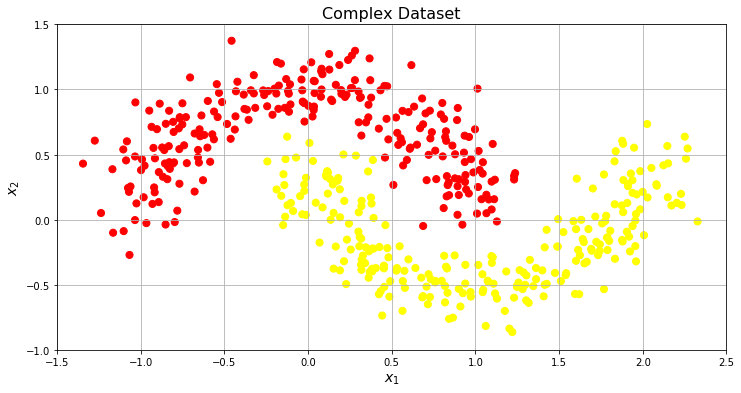

In [3]:
X, y = make_moons(n_samples=500, noise=0.15, random_state=42)

plt.figure(figsize=(12, 6))

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

plt.title("Complex Dataset", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.axis([-1.5, 2.5, -1, 1.5])
plt.grid(True, which='both')
plt.show()


## Split Data into Train-Test Set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Create A Scatter Plot of Train and Test Data

On the same figure we plot both the train and test data.

To separately show the test data, we use black "edgecolors" and slightly bigger marker size (using the "s" parameter).

More info on the parameters of matplotlib scatter plot.

https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html



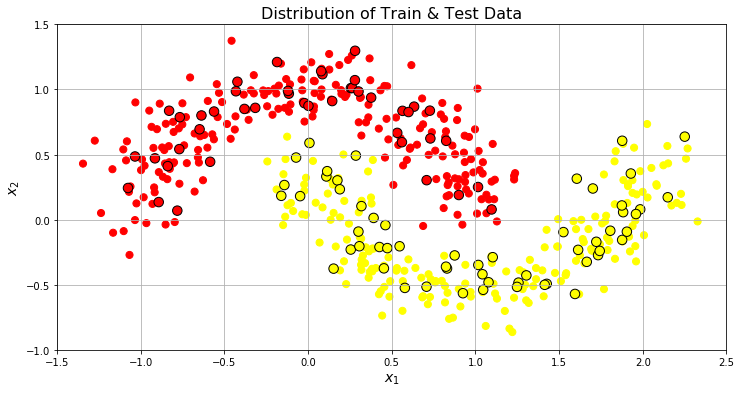

In [5]:
plt.figure(figsize=(12, 6))

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")

plt.title("Distribution of Train & Test Data", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.grid(True, which='both')
plt.axis([-1.5, 2.5, -1, 1.5])
plt.show()

## Data Scaling

The SVM classfication is influenced by the varying scale of the features.

SVMs try to fit the largest possible “street” between the classes. So if the training set is not scaled, the SVM will tend to neglect small features.

Thus, we should standardize the data before training.

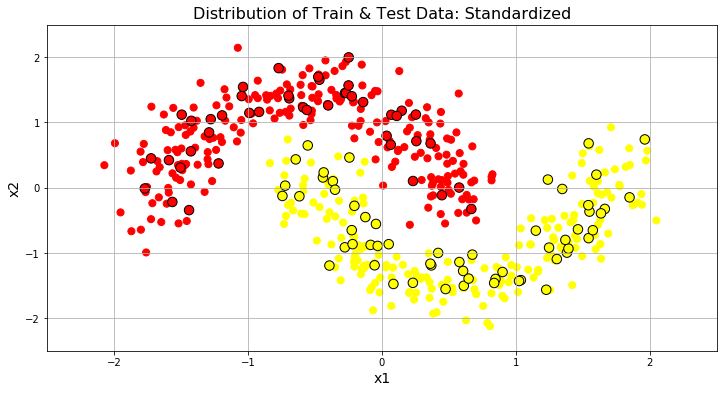

In [6]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = X_train_scaled
X_test = X_test_scaled


plt.figure(figsize=(12, 6))

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")

plt.title("Distribution of Train & Test Data: Standardized", fontsize=16)
plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.grid(True, which='both')
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.show()

## Empirical Investigation


To have a better empirical understanding of how $\gamma$ and $C$ influence the Gaussian RBF kernel SVM, we perform 3 experiments.

- Experiment 1: $\gamma$ = very large:  expect severe overfitting, no value of $C$ will improve.
- Experiment 2: $\gamma$ = very small:  expect severe underfitting. 
- Experiment 3: $\gamma$ = very small to small: By incresing $C$ we will be able to improve the training as well as test accuracy.

## Experiment 1: $\gamma$ = Very Large


For very large $\gamma$, the radius of the influence of the support vectors will be small. As a consequence it will only include the support vector itself.

It will result into severe **overfitting**.

Even if we apply regularization with C, it will not be able to eliminate overfitting.

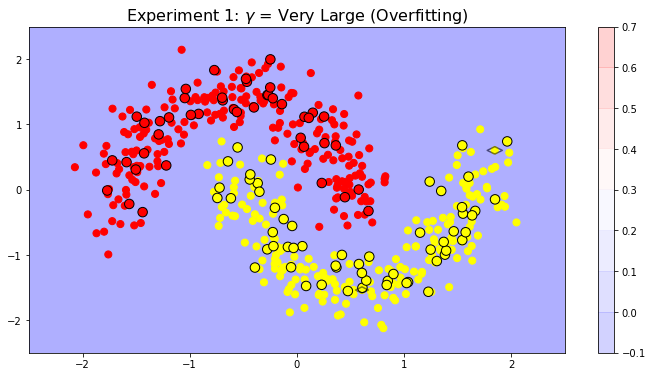

Training Accuracy:  1.0
Test Accuracy:  0.43

Test Confusion Matrix:
[[43  0]
 [57  0]]

Test Precision = 0.000000
Test Recall = 0.000000
Test F1 Score = 0.000000

Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60        43
           1       0.00      0.00      0.00        57

    accuracy                           0.43       100
   macro avg       0.21      0.50      0.30       100
weighted avg       0.18      0.43      0.26       100



/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
svm_rbf_clf = SVC(kernel="rbf", gamma=1000000)
svm_rbf_clf.fit(X_train, y_train)

y_train_predicted = svm_rbf_clf.predict(X_train)

plt.figure(figsize=(12, 6))
decision_boundary_svc_class_colored(svm_rbf_clf, X, plotDistanceFromHyperplane=True, colorBar=True)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")
plt.title("Experiment 1: $\\gamma$ = Very Large (Overfitting)", fontsize=16)
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.show()

print("Training Accuracy: ", svm_rbf_clf.score(X_train, y_train))

y_test_predicted = svm_rbf_clf.predict(X_test)
print("Test Accuracy: ", svm_rbf_clf.score(X_test, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

## Experiment 2: $\gamma$ = Very Small


Smaller $\gamma$ will result into **severe underfitting**. 

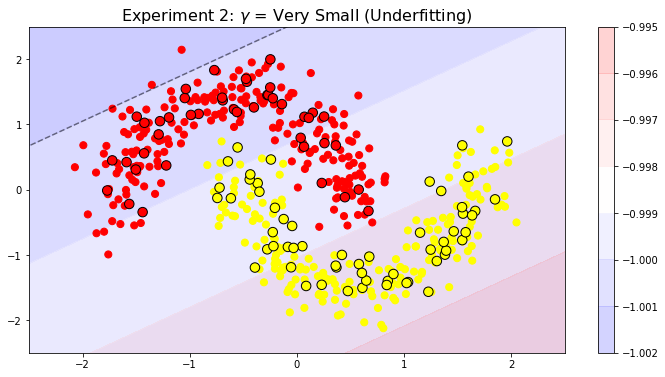

Training Accuracy:  0.5175
Test Accuracy:  0.43

Test Confusion Matrix:
[[43  0]
 [57  0]]

Test Precision = 0.000000
Test Recall = 0.000000
Test F1 Score = 0.000000

Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60        43
           1       0.00      0.00      0.00        57

    accuracy                           0.43       100
   macro avg       0.21      0.50      0.30       100
weighted avg       0.18      0.43      0.26       100



/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
svm_rbf_clf = SVC(kernel="rbf", gamma=0.000001)
svm_rbf_clf.fit(X_train, y_train)

y_train_predicted = svm_rbf_clf.predict(X_train)

plt.figure(figsize=(12, 6))
decision_boundary_svc_class_colored(svm_rbf_clf, X, plotDistanceFromHyperplane=True, colorBar=True)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")
plt.title("Experiment 2: $\\gamma$ = Very Small (Underfitting)", fontsize=16)
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.show()

print("Training Accuracy: ", svm_rbf_clf.score(X_train, y_train))
y_test_predicted = svm_rbf_clf.predict(X_test)
print("Test Accuracy: ", svm_rbf_clf.score(X_test, y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

## Experiment 3: $\gamma$ = Very Small to Small 

By incresing $C$ we will be able to improve the training as well as test accuracy (i.e., eliminate underfitting).

To better perform this part of the experimentation, we will vary $\gamma$ very small to small values, and $C$ from very large to small values.


Set the range of values for $\gamma$  and $C$.

- $\gamma$: very small to small [0.000001, 0.0001, 0.01, 0.1]
- $C$: very large (wide margin) to small (narrow margin) [10000000, 10000, 100, 10]


In [9]:
C_range = [10000000, 10000, 100, 10]
gamma_range = [0.000001, 0.0001, 0.01, 0.1]
classifiers = []
testAccuracy = []
for C in C_range:
    for gamma in gamma_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_train, y_train)
        y_test_predicted = clf.predict(X_test)
        testAccuracy.append(clf.score(X_test, y_test))
        classifiers.append((C, gamma, clf))

## Plot The Decision Boundary For Various Combinations of $\gamma$ and $C$

On these plots we show both the decision boundary and the test accuracy.

We observe that we get the best performance for:
   
       -- Smaller gamma (= 0.1) and Large C (=1000)

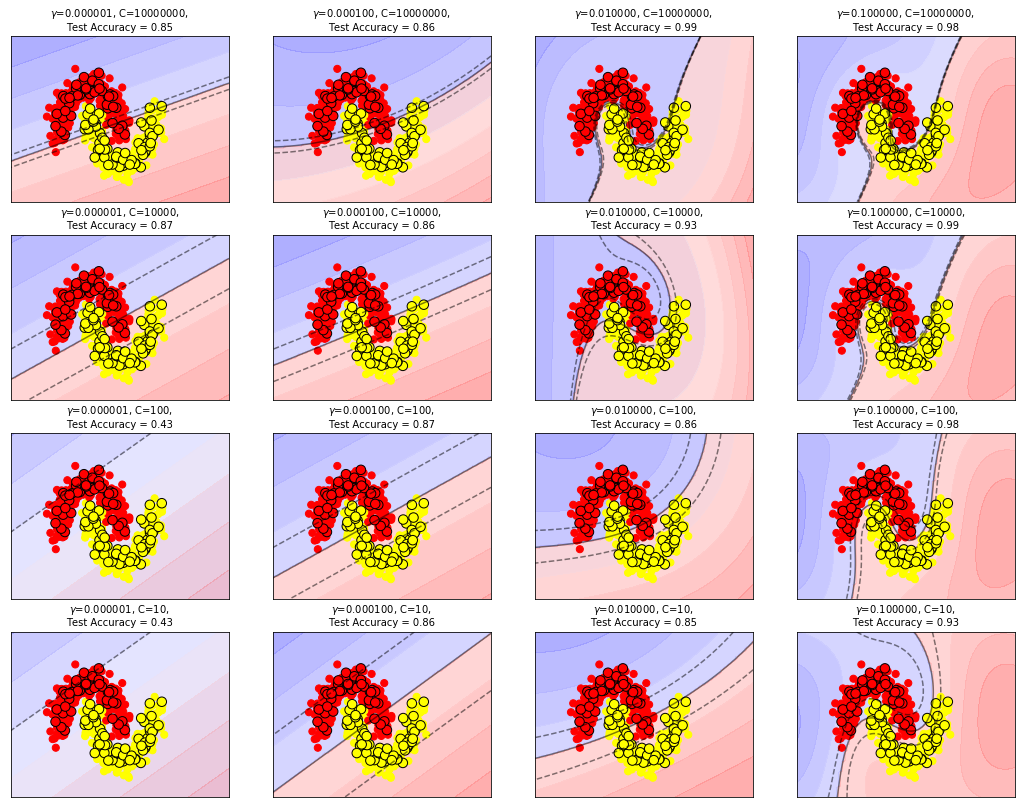

In [10]:
plt.figure(figsize=(18, 14))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    plt.subplot(len(C_range), len(gamma_range), k + 1)
    plt.title("$\\gamma$=%.6f, C=%.0f, \nTest Accuracy = %.2f" % (gamma, C, testAccuracy[k]), size='medium')

    # visualize parameter's effect on decision function
    decision_boundary_svc_class_colored(clf, X, plotDistanceFromHyperplane=True)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis([-2.5, 2.5, -2.5, 2.5])
    plt.axis('tight')

## Model Selection: Hyperparameter Tuning via Grid Search

Finally, we can perform a grid search to select the best model.

Based on the 3 experiments now we know how set the range for $\gamma$ and $C$.

- $\gamma$: very small to small 
- $C$: very large (wide margin) to small (narrow margin) 

We will extend these ranges a little bit to increse the search space.

In [11]:
%%time

param_grid = {'gamma': [0.000001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'C': [10, 100, 1000, 10000]}
clf = SVC()

clf_cv = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5)
clf_cv.fit(X_train, y_train)

params_optimal = clf_cv.best_params_

print("Best Score (accuracy): %f" % clf_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Best Score (accuracy): 0.997500
Optimal Hyperparameter Values:  {'C': 100, 'gamma': 1}


CPU times: user 354 ms, sys: 4.82 ms, total: 358 ms
Wall time: 358 ms


/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Train and Evaluate the Optimal Model

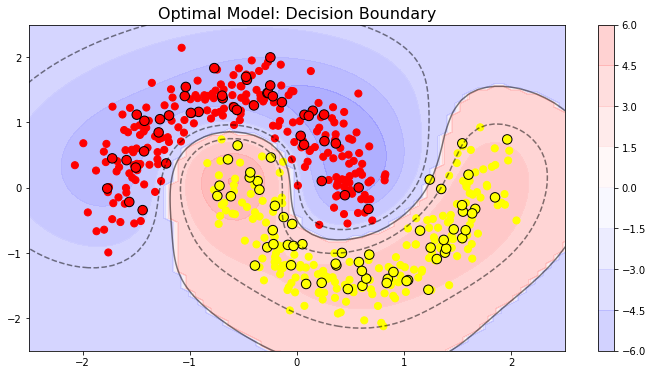

Training Accuracy:  1.0
Test Accuracy:  0.99

Test Confusion Matrix:
[[43  0]
 [ 1 56]]

Test Precision = 1.000000
Test Recall = 0.982456
Test F1 Score = 0.991150

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.98      0.99        57

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [12]:
svm_rbf_clf = SVC(kernel="rbf", **params_optimal)
svm_rbf_clf.fit(X_train, y_train)

y_train_predicted = svm_rbf_clf.predict(X_train)

plt.figure(figsize=(12, 6))
decision_boundary_svc_class_colored(svm_rbf_clf, X, plotDistanceFromHyperplane=True, colorBar=True)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")
plt.title("Optimal Model: Decision Boundary", fontsize=16)
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.show()


print("Training Accuracy: ", svm_rbf_clf.score(X_train, y_train))
y_test_predicted = svm_rbf_clf.predict(X_test)
print("Test Accuracy: ", svm_rbf_clf.score(X_test, y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))